In [1]:
%reset-f

In [1]:

%load_ext autoreload
%autoreload
%matplotlib inline
from fancy_plots import fancy_barh

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("always",category=UserWarning)
from res_ind_lib import *
import os



import matplotlib as mpl





import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
os.makedirs("catfi",exist_ok=True)

font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}

plt.rc('font', **font)
plt.rcParams["legend.fancybox"]=True
plt.rcParams["savefig.dpi"]=90

In [3]:
target_loss_sharing = .5
ddo_over_gdp_max=0.5/100

def share_spent_scale_up(df):
    return .5*(df.borrow_abi+df.prepare_scaleup)*target_loss_sharing*df.v*df.fa*df.avg_prod_k*df.macro_multiplier


def abi_max(df):
    delta =  2*ddo_over_gdp_max/(target_loss_sharing*df.v*df.fa*df.avg_prod_k*df.macro_multiplier) 
    return (df.borrow_abi + delta.clip(lower=0)).clip(upper=1)


### Data

C:\Users\Admin\Box Sync\PYTHON - RESILIENCE\resilience_indicator_wp\fancy_plots.py:19: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  data=data.sort_index(by=data.columns[0])


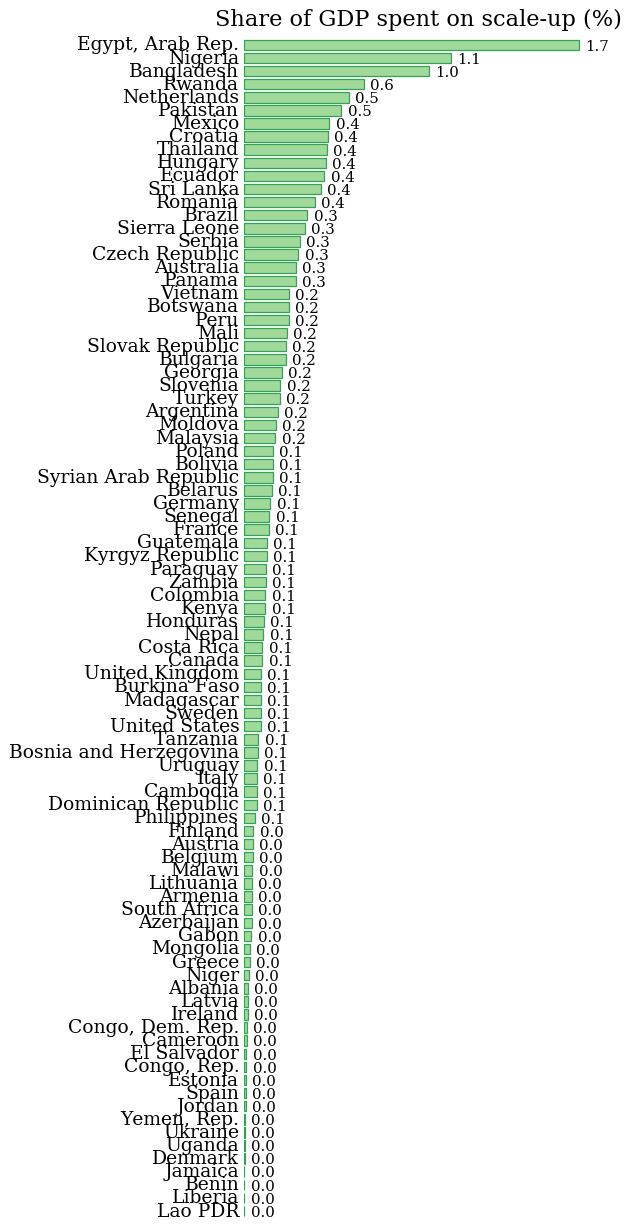

In [8]:
#orignal situation
df=pd.read_csv("results/df.csv",index_col="country").dropna().drop(["iso3","original_country"],axis=1)
df_ = df.copy(deep=True)
df["share_gdp_scaled_up"] = share_spent_scale_up(df)

plt.figure(figsize=(5,17))

fancy_barh(df[["share_gdp_scaled_up"]]);
plt.title("Share of GDP spent on scale-up (%)");
plt.savefig("catfi/share_spent_scale_up.png",bbox_inches = 'tight')

## Improvements

In [9]:
#removes constraint on brorrowing up to cat_ddo_abi_max(df)
a=abi_max(df)
df_cat_ddo = df.assign(rating=a, finance_pre=a)

df_cat_ddo= compute_resiliences(df_cat_ddo)
df["shared_spent_cat_ddo"]=share_spent_scale_up(df_cat_ddo)
(df["shared_spent_cat_ddo"]-df.share_gdp_scaled_up).max() #should be .5%

0.0049999871271228782

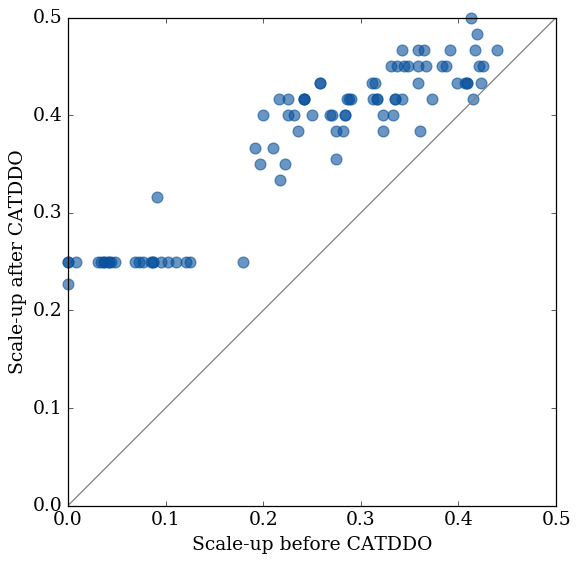

In [10]:
plt.figure(figsize=(7,7))
plt.scatter(df["sigma_p"],df_cat_ddo["sigma_p"],alpha=0.6,s=75,clip_on=False,color="#08519c")
plt.xlabel("Scale-up before CATDDO")
plt.ylabel("Scale-up after CATDDO")
plt.xlim(0);plt.ylim(0,.5) 
plt.plot([0 , 1],[0, 1],color="gray")
plt.savefig("catfi/scale_up_before_after_first")

In [11]:
#adds a plan and removes constraint on brorrowing up to cat_ddo_abi_max(df)
df_plan = df.assign(prepare_scaleup=1)
df["shared_spent_plan"]=share_spent_scale_up(df_plan)
a=abi_max(df_plan)
df_cat_ddo_plan = df_plan.assign(rating=a, finance_pre=a)

df_cat_ddo_plan= compute_resiliences(df_cat_ddo_plan)
df["shared_spent_cat_ddo_plan"]=share_spent_scale_up(df_cat_ddo_plan)
(df["shared_spent_cat_ddo_plan"]-df["shared_spent_plan"]).max() #should be .5%

0.0049999729845784041

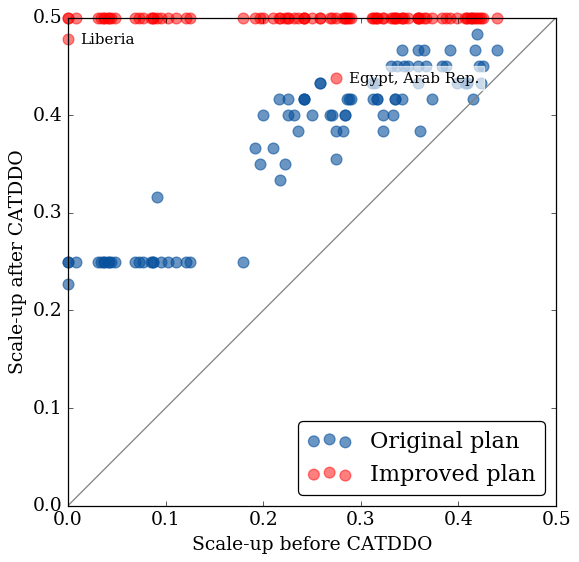

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(df["sigma_p"],df_cat_ddo["sigma_p"],alpha=0.6,s=75,clip_on=False,color="#08519c")

x_ = df["sigma_p"]
y_ = df_cat_ddo_plan["sigma_p"]

plt.scatter(x_,y_,color='red',s=75,alpha=.5,clip_on=False)
plt.xlabel("Scale-up before CATDDO")
plt.ylabel("Scale-up after CATDDO")
plt.legend(["Original plan","Improved plan"],loc="lower right")

plt.xlim(0);plt.ylim(0,.5) 
plt.plot([0 , 1],[0, 1],color="gray")

logical = a<1
if (logical is not None) :
        for label, x, y in zip(df.index[logical], x_[logical], y_[logical]):
            plt.annotate(
                label, 
                xy = (x, y), xytext = (10, 0),
                textcoords = 'offset points', ha = 'left', va = 'center', size = 12,
                bbox = dict( fc = 'white', ec="white", alpha = 0.65),
                #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
              
            )

plt.savefig("catfi/scale_up_before_after",bbox_inches = 'tight')

## Barplots effect of CATDDO

In [14]:
data = pd.DataFrame()
data["CATDDO"] = (df_cat_ddo-df).resilience
data["CATDDO + Plan"]= (df_cat_ddo_plan - df).resilience




C:\Users\Admin\Box Sync\PYTHON - RESILIENCE\resilience_indicator_wp\fancy_plots.py:19: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  data=data.sort_index(by=data.columns[0])


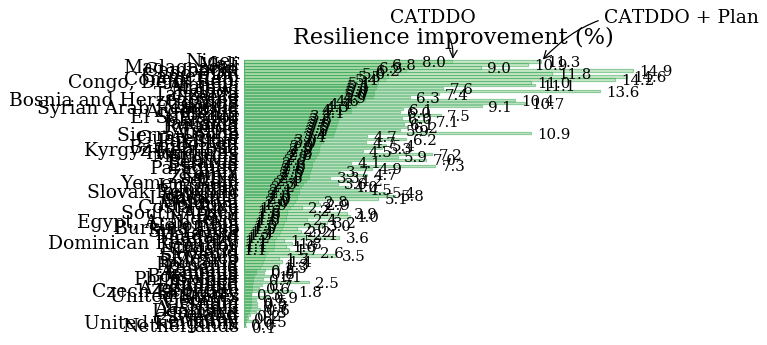

In [15]:
fancy_barh(data)
plt.title("Resilience improvement (%)")
plt.savefig("catfi/improv",bbox_inches = 'tight')

## Maps : to reod with new map lib

In [12]:
from maps_lib import *
from IPython.display import SVG,Image

In [13]:
#All data in one df
df["resi_cat_ddo_plan"] = df_cat_ddo_plan.resilience-df.resilience
df["resi_cat_ddo"] = df_cat_ddo.resilience-df.resilience

In [14]:
c_to_iso2=pd.read_csv("names_to_iso.csv",usecols=["country","iso2"],index_col="country",squeeze=True)
c_to_iso2;

In [15]:
df = df.reset_index()
iso2= df["country"].replace(c_to_iso2)
df["iso2"]=iso2
df=df.set_index("country")
[c for c in iso2 if c not in c_to_iso2.values] #List of countries not recognized (should be empty)

[]

In [16]:
def make_legend(serie,label,path):
    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

    cmap = mpl.cm.get_cmap("Greens")
    vmin=(100*serie.min())
    vmax=(100*serie.max())

    # define the bins and normalize
    bounds =np.linspace(vmin,vmax,7)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal', format="%2.1f")
    #cb.ax.set_xticklabels(['0.01%','0.1%','1%','10%'])
    cb.set_label(label,size=20)

    plt.savefig(path,bbox_inches="tight",transparent=True)    

In [17]:
df["cat_ddo_color"]=data_to_rgb(df["resi_cat_ddo"],plt.cm.get_cmap("Greens"),bins_normalizer,5)
df["cat_ddo_color_plan"]=data_to_rgb(df["resi_cat_ddo_plan"],plt.cm.get_cmap("Greens"),bins_normalizer,5)

style_base =\
""".landxx.{iso2}
{{  
   fill: {color};
   stroke:#000000;
   stroke-width:0.3;
   fill-rule:evenodd;
}}"""

styles_plan= styles=""
for c in df.index:
    styles +=  style_base.format(iso2=df["iso2"][c].lower(),color=df["cat_ddo_color"][c])+ "\n"
    styles_plan +=  style_base.format(iso2=df["iso2"][c].lower(),color=df["cat_ddo_color_plan"][c])+ "\n"
  
    
append_styles_to_map("catfi/map_of_catddo",styles)
    
append_styles_to_map("catfi/map_of_catddo_plan",styles_plan)


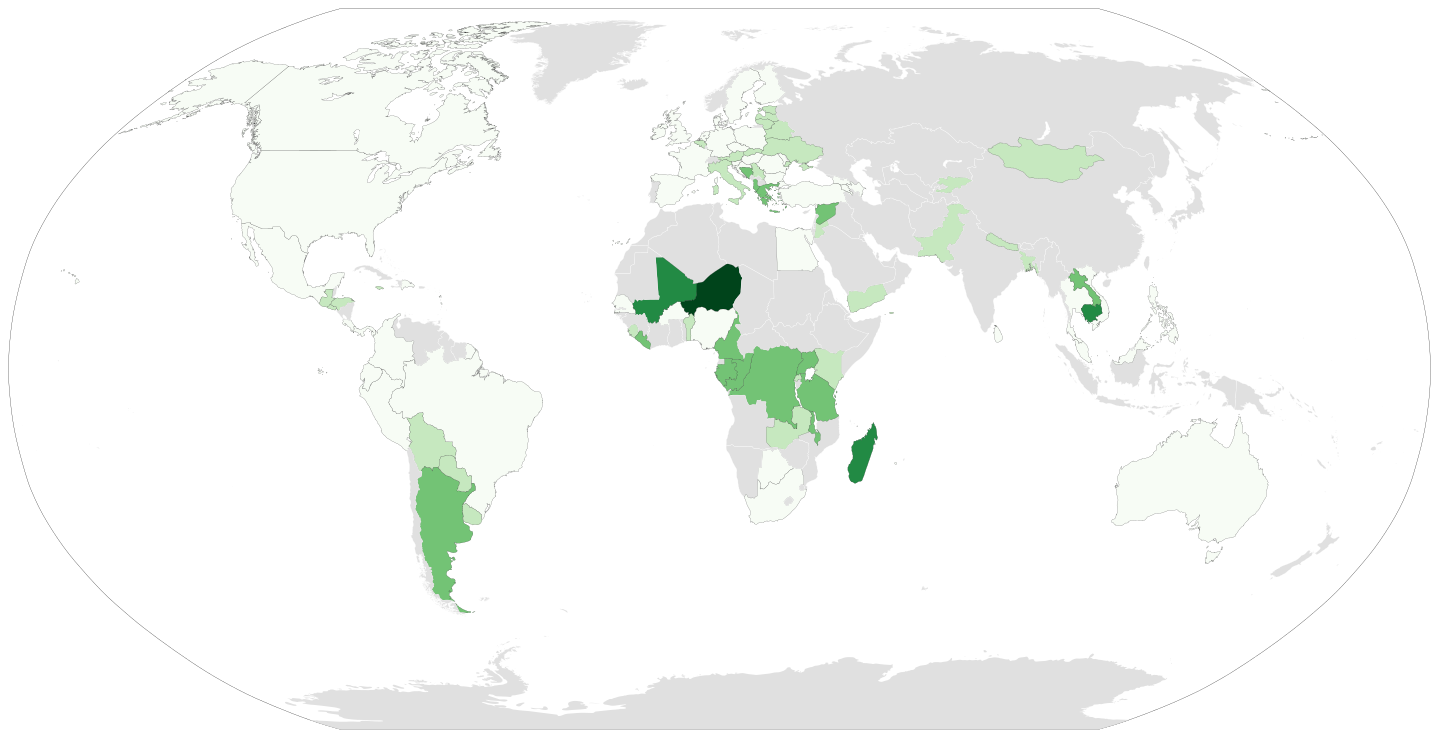

In [18]:
Image("catfi/map_of_catddo.png",width=700)

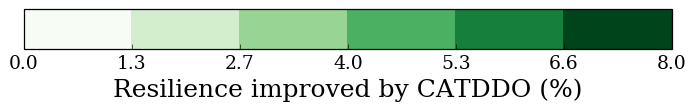

In [19]:
path = "catfi/legend_cat_ddo.png"
serie =df["resi_cat_ddo"]
label = 'Resilience improved by CATDDO (%)'

make_legend(serie,label,path)

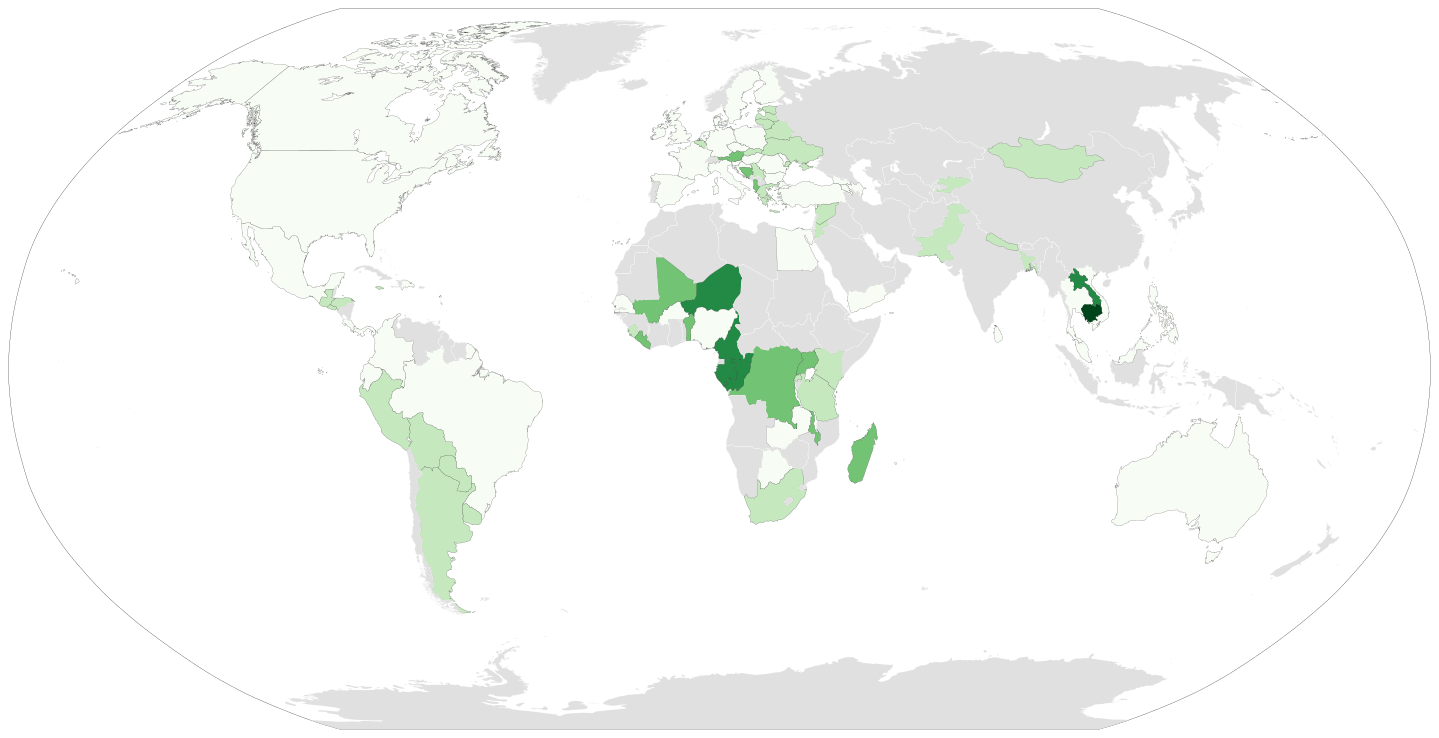

In [20]:
Image("catfi/map_of_catddo_plan.png",width=700)

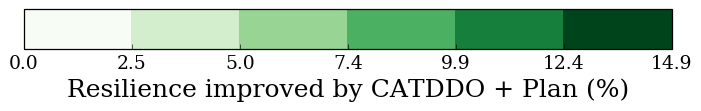

In [21]:
path = "catfi/legend_cat_ddo_plan.png"
serie =df["resi_cat_ddo_plan"]
label = 'Resilience improved by CATDDO + Plan (%)'

make_legend(serie,label,path)

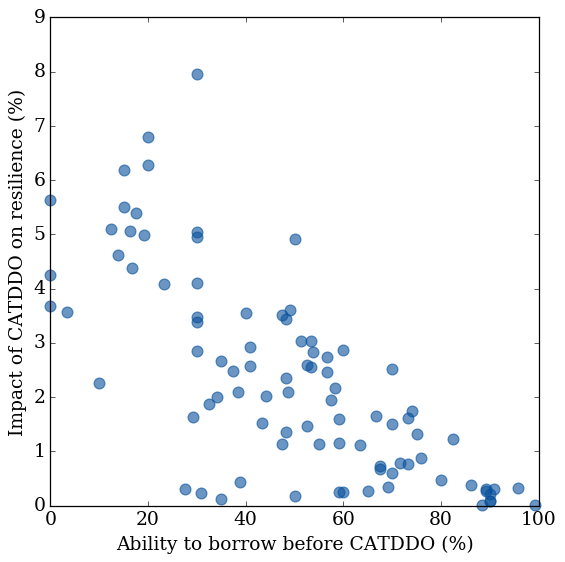

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(df.borrow_abi*100,100*df.resi_cat_ddo,alpha=0.6,s=75,clip_on=False,color="#08519c")
plt.xlabel("Ability to borrow before CATDDO (%)")
plt.ylabel("Impact of CATDDO on resilience (%)")
plt.xlim(0,100);plt.ylim(0) 
plt.savefig("catfi/catddo_vs_borrow")

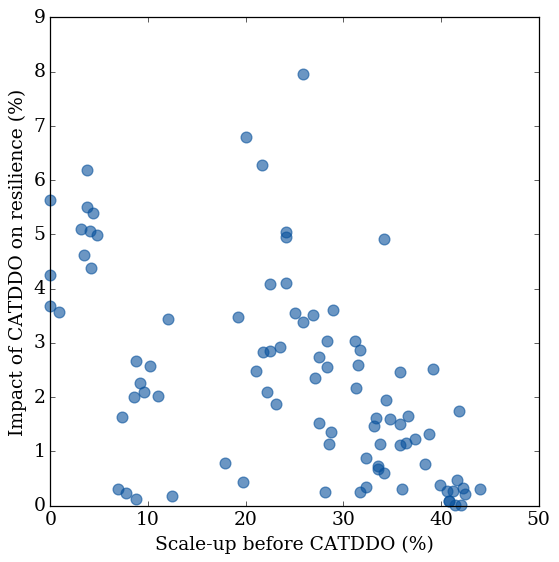

In [23]:
plt.figure(figsize=(7,7))
plt.scatter(df.sigma_p*100,100*df.resi_cat_ddo,alpha=0.6,s=75,clip_on=False,color="#08519c")
plt.xlabel("Scale-up before CATDDO (%)")
plt.ylabel("Impact of CATDDO on resilience (%)")
plt.xlim(0,50);plt.ylim(0) 
plt.savefig("catfi/catddo_vs_scalup")

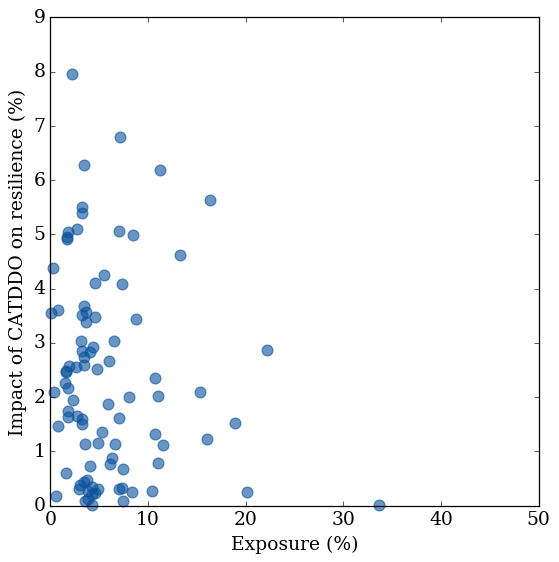

In [24]:
plt.figure(figsize=(7,7))
plt.scatter(df.fa*100,100*df.resi_cat_ddo,alpha=0.6,s=75,clip_on=False,color="#08519c")
plt.xlabel("Exposure (%)")
plt.ylabel("Impact of CATDDO on resilience (%)")
plt.xlim(0,50);plt.ylim(0) 
plt.savefig("catfi/catddo_vs_exposure")

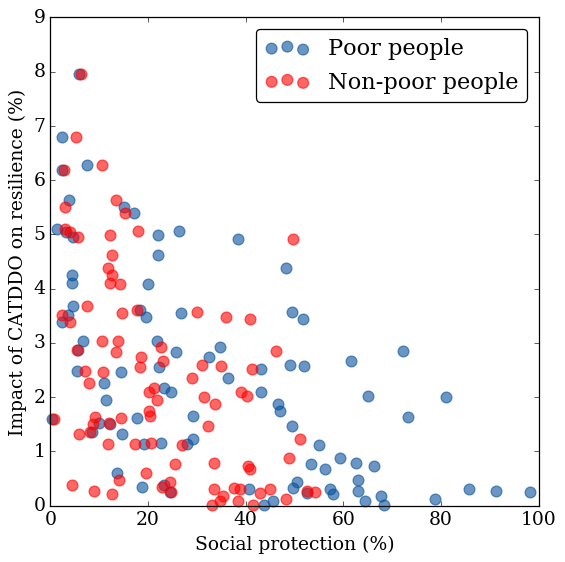

In [25]:
plt.figure(figsize=(7,7))
plt.scatter(df.social_p*100,100*df.resi_cat_ddo,alpha=0.6,s=75,clip_on=False,color="#08519c")
plt.scatter(df.social_r*100,100*df.resi_cat_ddo,alpha=0.6,s=75,clip_on=False,color="red")
plt.xlabel("Social protection (%)")
plt.ylabel("Impact of CATDDO on resilience (%)")
plt.xlim(0,100);plt.ylim(0) 
plt.legend(["Poor people", "Non-poor people"],loc="upper right")
plt.savefig("catfi/catddo_vs_social")

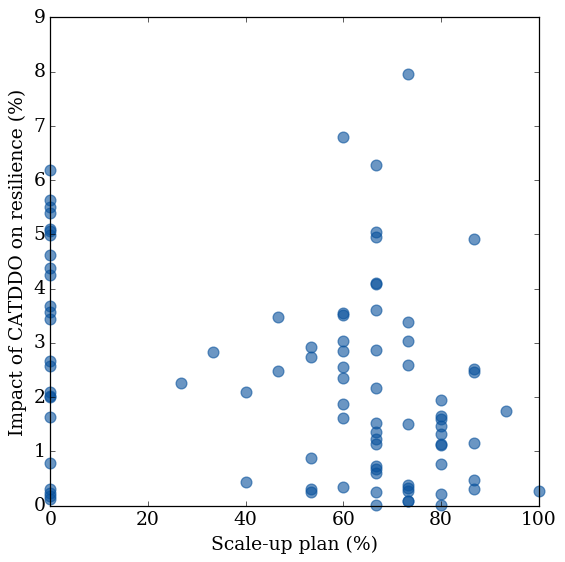

In [26]:
plt.figure(figsize=(7,7))
plt.scatter(df.prepare_scaleup*100,100*df.resi_cat_ddo,alpha=0.6,s=75,clip_on=False,color="#08519c")
plt.xlabel("Scale-up plan (%)")
plt.ylabel("Impact of CATDDO on resilience (%)")
plt.xlim(0,100);plt.ylim(0) 
plt.savefig("catfi/catddo_vs_prepare_scale_up")